In [1]:
#from scipy import stats
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
#from scipy.optimize import curve_fit
#%matplotlib inline
# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from tqdm import tqdm
import corner

10.05039834762554 3.1937357089544376


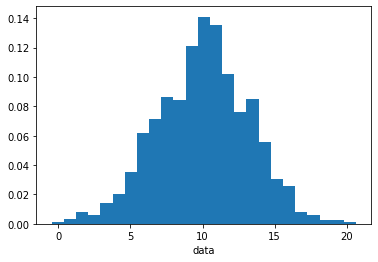

In [3]:
N = 1000
data = np.random.normal(loc=10, scale=3.0, size=N) + np.random.uniform(-1,1,N)#np.random.random(N)

bin_heights, bin_borders, _ = plt.hist(data, bins='auto',range=(min(data),max(data)),density=True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
plt.xlabel('data')
print(np.mean(data),np.std(data))

In [4]:
def log_likelihood(params, x):
    std, mu = params
    Ac = -0.5*((x - mu)/std)**2
    y = 1/(np.sqrt(2 * np.pi * std**2)) * np.exp( Ac )
    # Calculate log likelihood
    return np.sum(np.log(y))

# def log_likelihood(params, x):
#     std, mu = params
#     # Calculate negative log likelihood
#     N = len(x)
#     return -0.5 * N * np.log(2 * np.pi) - N * np.log(std) - 0.5* np.sum(((x - mu)/std)**2)

def log_prior(params):
    std, mu = params
    if 0.0 < std < 10.0 and 0.0 < mu < 20.0:
        return 0.0
    return -np.inf

def log_probability(params, x):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x)

In [5]:
sample_data = data
std, mu = np.std(sample_data), np.mean(sample_data)
initparams = [std, mu]
print(initparams)
print(log_likelihood(initparams, sample_data))
print(log_prior(initparams))
print(log_probability(initparams, sample_data))

nll = lambda *args: -log_likelihood(*args)

results = minimize(nll, initparams, args=(sample_data), options={"disc":True}, method='Nelder-Mead')
results.x

[3.1937357089544376, 10.05039834762554]
-2580.129833473169
0.0
-2580.129833473169


array([ 3.19373571, 10.05039835])

In [7]:
def Metropolis(params, data, a = 0.1, NSteps = int(3e4)):
    x = np.ones(( NSteps, len(params) ))
    x[0] = params
    #x[0] = [np.random.rand(),np.random.rand(),np.random.rand(),np.random.rand(),np.random.rand()]
    
    for i in tqdm(range(1, NSteps)):
        std = x[i-1,0] + a * np.random.normal(loc=0, scale=1.0)
        mu = x[i-1,1] + a * np.random.normal(loc=0, scale=1.0)
        
        #present = log_likelihood(params) + log_prior(params)
        #future = log_likelihood([std, mu]) + log_prior([std, mu])
        present = log_probability(params, data)
        future = log_probability([std, mu], data)

        alpha = np.minimum(1, np.exp( future - present ))
        g = np.random.rand()
        
        if alpha > g:
            x[i,0] = std
            x[i,1] = mu
        else:
            x[i,:] = x[i-1,:]       
         
    return x[100:,:] # quemamos los primeros xxxx puntos

In [8]:
initparams = results.x
MCMC = Metropolis(initparams, sample_data, 0.1, 100000)

100%|██████████| 99999/99999 [00:12<00:00, 7926.64it/s]


Minimize: [ 3.19373571 10.05039835]
MCMC:     [ 3.19703463 10.04934721]


Text(0.5, 0, 'step number')

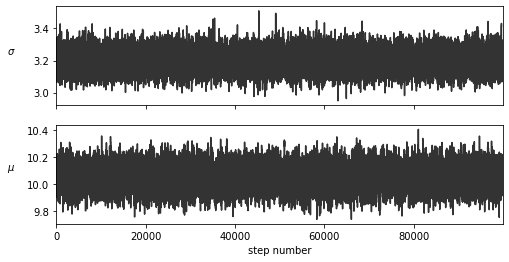

In [9]:
params_mcmc = np.percentile(MCMC ,50, axis=0)
print('Minimize:',results.x)
print('MCMC:    ',params_mcmc)

fig, axes = plt.subplots(len(params_mcmc), figsize=(8, 4), sharex=True)
labels = ["$\sigma$", "$\mu$"]
for i in range(len(params_mcmc)):
    ax = axes[i]
    ax.plot(MCMC[:,i], 'k', alpha=0.8)
    ax.set_xlim(0, len(MCMC))
    ax.set_ylabel(labels[i], rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

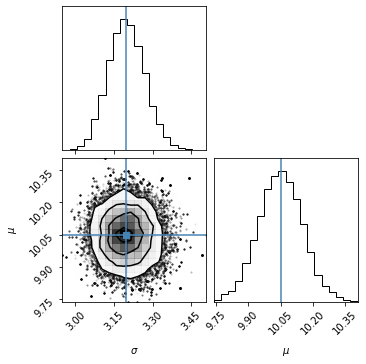

In [10]:
truths = np.percentile(MCMC ,50, axis=0)
labels = ["$\sigma$", "$\mu$"]

figure = corner.corner(MCMC, labels=labels, truths=truths)

(66454, 20)


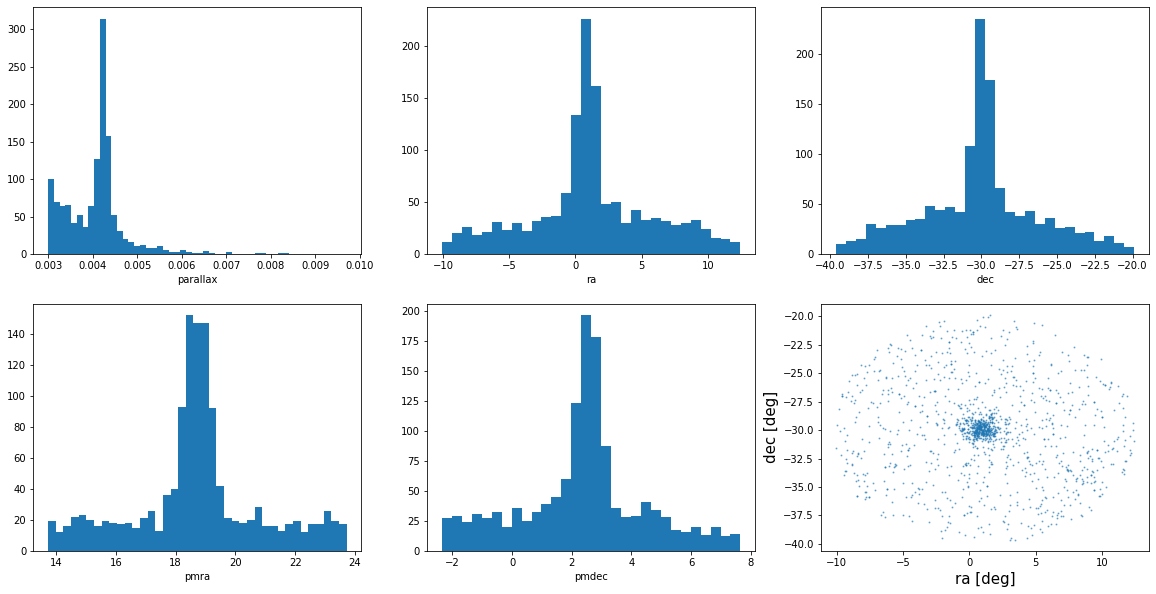

1319


In [11]:
df = pd.read_csv('./blanco1_10.csv')
df.loc[df['ra'] > 300, 'ra'] -= 360 #SOLO PARA BLANCO 1
df = df.fillna(0)
df['parallax'] = df['parallax'] / 1000
df['parallax_error'] = df['parallax_error'] / 1000
print(df.shape)

mu_alpha, mu_delta = 18.724, 2.650
rango = 5
c_pm=(df['pmra'] > mu_alpha - rango) & (df['pmra'] < mu_alpha + rango) & \
                        (df['pmdec'] > mu_delta - rango) & (df['pmdec'] < mu_delta + rango)
c_p = (df['parallax'] > 0.003) & (df['parallax'] < 0.01)

df = df[c_pm & c_p]

plt.figure(figsize=(20,10))

plt.subplot(2,3,1)
plt.hist(df.parallax,bins='auto')
plt.xlabel('parallax')

plt.subplot(2,3,2)
plt.hist(df.ra,bins='auto')
plt.xlabel('ra')

plt.subplot(2,3,3)
plt.hist(df.dec,bins='auto')
plt.xlabel('dec')

plt.subplot(2,3,4)
plt.hist(df.pmra,bins='auto')
#plt.xlim(-100,100)
plt.xlabel('pmra')

plt.subplot(2,3,5)
plt.hist(df.pmdec,bins='auto')
#plt.xlim(-100,100)
plt.xlabel('pmdec')

plt.subplot(2,3,6)
plt.scatter(df['ra'], df['dec'], marker='o' , s=1, alpha = 0.5)
plt.xlabel("ra [deg]",  fontsize = 15)
plt.ylabel("dec [deg]",  fontsize = 15)#,rotation=0)
#plt.xlim(-30,0)
#plt.ylim(0,30)
plt.show()

print(len(df))

In [ ]:
# nwalkers, ndim = 250, 2
# #p0 = [results_pmra.x + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
# p0 = results_pmra.x * np.random.randn(nwalkers, ndim)
# #p0 = [np.random.rand(ndim) for i in range(nwalkers)]

# import emcee
# sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=[sample_data])
# pos, prob, state = sampler.run_mcmc(p0, 5000, progress=True)

# #samples = sampler.chain
# samples = sampler.get_chain()
# labels = ["$\sigma$", "$\mu$"]
# fig, axes = plt.subplots(ndim, figsize=(8, 4), sharex=True)
# for i in range(ndim):
#     ax = axes[i]
#     ax.plot(samples[:, :, i], "k", alpha=0.2)
#     #ax.plot(pos[:, i], "k", alpha=0.3)
#     ax.set_xlim(0, len(samples))
#     ax.set_ylabel(labels[i], rotation=0)
#     ax.yaxis.set_label_coords(-0.1, 0.5)
# axes[-1].set_xlabel("step number")

# tau = sampler.get_autocorr_time()
# print(tau)
# flat_samples = sampler.get_chain(discard=50, flat=True)
# print(flat_samples.shape)

# maxprob_indice = np.argmax(prob)
# sigma_fit, mean_fit = pos[maxprob_indice]

# import corner
# fig = corner.corner(flat_samples, labels=labels, truths=[sigma_fit, mean_fit])

# Two Gaussian functions

In [12]:
def log_likelihood(params, x):
    nc, sc, sf, mu_c, mu_f = params
    Ac = -0.5*((x - mu_c)/sc)**2
    Be = -0.5*((x - mu_f)/sf)**2
    y = nc/(np.sqrt(2*np.pi)*sc)*np.exp(Ac) + (1-nc)/(np.sqrt(2*np.pi)*sf)*np.exp(Be)
    # Calculate log likelihood
    return np.sum(np.log(y))

def log_prior(params):
    nc, sc, sf, mu_c, mu_f = params
    if 0.0 < nc < 1.0 and 0.0 < sc < 10.0 and 0.0 < sf < 10.0:
        return 0.0
    return -np.inf

def log_probability(params, x):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x)

def gaussian_function(x, params):
    nc, sc, sf, mu_c, mu_f = params
    Ac = -0.5*((x - mu_c)/sc)**2
    Be = -0.5*((x - mu_f)/sf)**2
    return nc/(np.sqrt(2*np.pi)*sc)*np.exp(Ac) + (1-nc)/(np.sqrt(2*np.pi)*sf)*np.exp(Be)

In [13]:
sample_data = df.pmra
sc, sf = np.std(sample_data)/2, np.std(sample_data)
mu_c, mu_f = np.mean(sample_data), np.mean(sample_data)
initparams_pmra = [0.5, sc, sf, mu_c, mu_f]
print(log_likelihood(initparams_pmra, sample_data))
print(log_prior(initparams_pmra))
print(log_probability(initparams_pmra, sample_data))

nll = lambda *args: -log_likelihood(*args)

results_pmra = minimize(nll, initparams_pmra, args=(sample_data), options={"disc":True}, method='Nelder-Mead')
results_pmra.x

-2852.3081625105388
0.0
-2852.3081625105388


array([ 0.39165834,  0.37660488,  2.71058927, 18.71690849, 18.70933123])

In [14]:
sample_data = df.pmdec
sc, sf = np.std(sample_data)/2, np.std(sample_data)
mu_c, mu_f = np.mean(sample_data), np.mean(sample_data)
initparams_pmdec = [0.5, sc, sf, mu_c, mu_f]
print(log_likelihood(initparams_pmdec, sample_data))
print(log_prior(initparams_pmdec))
print(log_probability(initparams_pmdec, sample_data))

nll = lambda *args: -log_likelihood(*args)

results_pmdec = minimize(nll, initparams_pmdec, args=(sample_data), options={"disc":True}, method='Nelder-Mead')
results_pmdec.x

-2856.0739944859038
0.0
-2856.0739944859038


array([0.30474692, 0.31997932, 2.48877737, 2.58162045, 2.2785303 ])

Text(0.5, 0, 'pmdec')

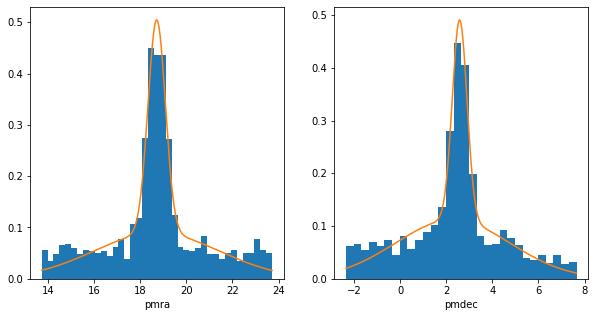

In [15]:
plt.figure(figsize=(10,5))
sample_data = df.pmra
plt.subplot(1,2,1)
bin_heights, bin_borders, _ = plt.hist(sample_data, bins='auto',
                                       range=(min(sample_data),max(sample_data)),density=True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x, gaussian_function(x, results_pmra.x))
plt.xlabel('pmra')

plt.subplot(1,2,2)
sample_data = df.pmdec
bin_heights, bin_borders, _ = plt.hist(sample_data, bins='auto',
                                       range=(min(sample_data),max(sample_data)),density=True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x, gaussian_function(x, results_pmdec.x))
plt.xlabel('pmdec')

In [16]:
def Metropolis(params, data, a = 0.1, NSteps = int(3e4)):
    
    x = np.ones(( NSteps, len(params) ))
    x[0] = params
    #x[0] = [np.random.rand(),np.random.rand(),np.random.rand(),np.random.rand(),np.random.rand()]
    
    for i in tqdm(range(1, NSteps)):
        nc = x[i-1,0] + a * np.random.normal(loc=0, scale=1.0)
        sc = x[i-1,1] + a * np.random.normal(loc=0, scale=1.0)
        sf = x[i-1,2] + a * np.random.normal(loc=0, scale=1.0)
        mu_c = x[i-1,3] + a * np.random.normal(loc=0, scale=1.0)
        mu_f = x[i-1,4] + a * np.random.normal(loc=0, scale=1.0)
        
        present = log_probability(params, data)
        future = log_probability([nc,sc,sf,mu_c,mu_f], data)

        alpha = np.minimum(1, np.exp( future - present ))
        g = np.random.rand() 
        
        if alpha > g:
            x[i,0] = nc
            x[i,1] = sc
            x[i,2] = sf
            x[i,3] = mu_c
            x[i,4] = mu_f
        else:
            x[i,:] = x[i-1,:]       
         
    return x[100:,:] # burn-in the first xxxx points

In [26]:
sample_data = df.pmra
initparams = results_pmra.x
MCMC = Metropolis(initparams, sample_data, 0.01, 100000)

100%|██████████| 99999/99999 [05:51<00:00, 284.66it/s]  


Minimize: [ 0.39165834  0.37660488  2.71058927 18.71690849 18.70933123]
MCMC:     [ 0.39413031  0.37989307  2.72228509 18.71549373 18.69500541]


Text(0.5, 0, 'step number')

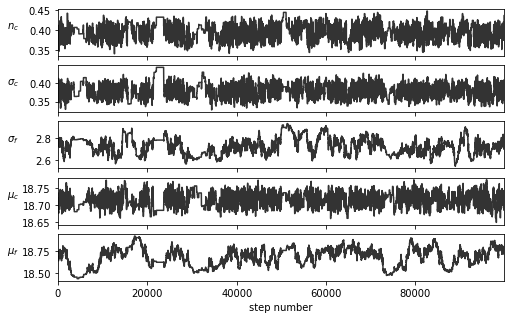

In [27]:
params_mcmc_pmra = np.percentile(MCMC ,50, axis=0)
print('Minimize:',results_pmra.x)
print('MCMC:    ',params_mcmc_pmra)

fig, axes = plt.subplots(len(params_mcmc_pmra), figsize=(8, 5), sharex=True)
labels = ["$n_c$", "$\sigma_c$", "$\sigma_f$", "$\mu_c$", "$\mu_f$"]
for i in range(len(params_mcmc_pmra)):
    ax = axes[i]
    ax.plot(MCMC[:,i], "k", alpha=0.8)
    ax.set_xlim(0, len(MCMC))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

In [25]:
# q1 = np.quantile(MCMC, q=[0.16,0.84],axis=0)
# errorsup = q1[1] -params_mcmc_pmra
# errorinf = params_mcmc_pmra - q1[0]
# print(errorsup)
# print(errorinf)
# print(results_pmra.x)

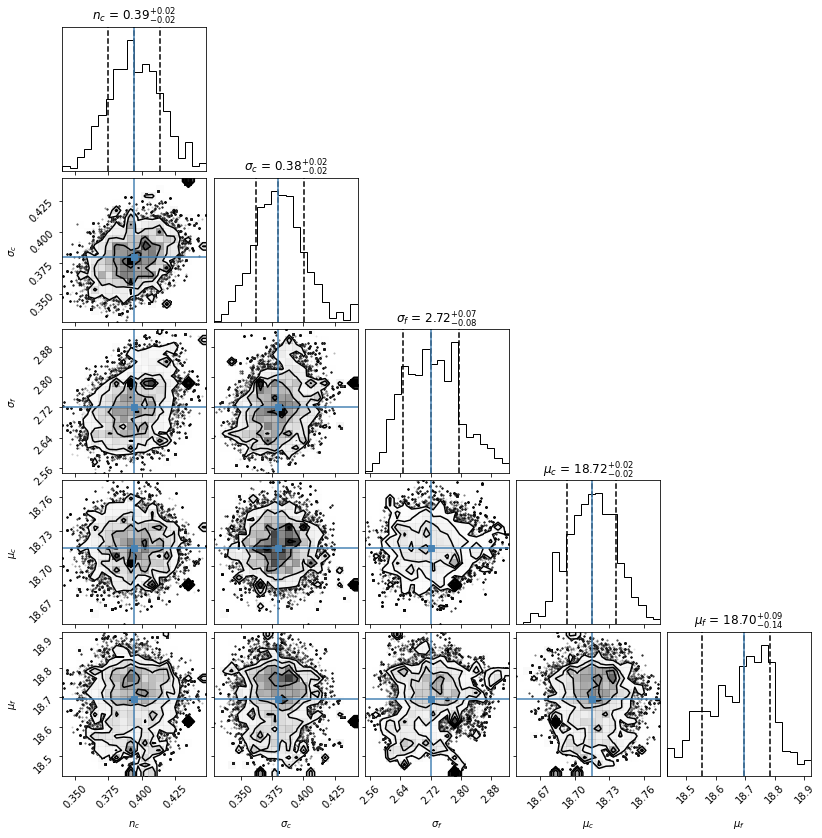

In [28]:
truths = np.percentile(MCMC ,50, axis=0)
labels = ["$n_c$", "$\sigma_c$", "$\sigma_f$", "$\mu_c$", "$\mu_f$"]

figure = corner.corner(MCMC, labels=labels, truths=truths, quantiles=[0.16, 0.5, 0.84], show_titles=True,
                      title_kwargs={"fontsize": 12})

In [29]:
sample_data = df.pmdec
initparams = results_pmdec.x
MCMC = Metropolis(initparams, sample_data, 0.01, 100000)

100%|██████████| 99999/99999 [05:59<00:00, 277.83it/s]


Minimize: [0.30474692 0.31997932 2.48877737 2.58162045 2.2785303 ]
MCMC:     [0.30450727 0.32370682 2.49172785 2.58485008 2.27699543]


Text(0.5, 0, 'step number')

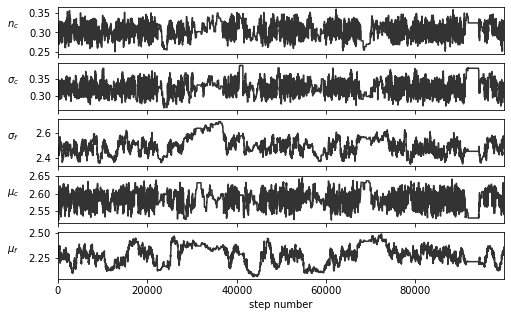

In [30]:
params_mcmc_pmdec = np.percentile(MCMC ,50, axis=0)
print('Minimize:',results_pmdec.x)
print('MCMC:    ',params_mcmc_pmdec)

fig, axes = plt.subplots(len(params_mcmc_pmdec), figsize=(8, 5), sharex=True)
labels = ["$n_c$", "$\sigma_c$", "$\sigma_f$", "$\mu_c$", "$\mu_f$"]
for i in range(len(params_mcmc_pmdec)):
    ax = axes[i]
    ax.plot(MCMC[:,i], "k", alpha=0.8)
    ax.set_xlim(0, len(MCMC))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

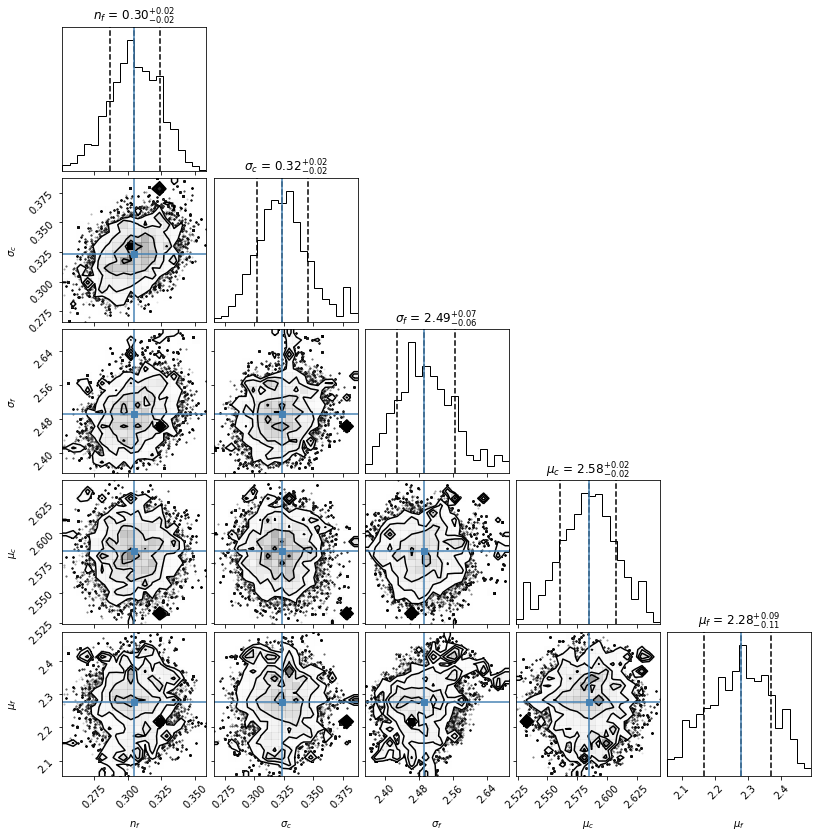

In [31]:
truths = np.percentile(MCMC ,50, axis=0)
labels = ["$n_f$", "$\sigma_c$", "$\sigma_f$", "$\mu_c$", "$\mu_f$"]

figure = corner.corner(MCMC, labels=labels, truths=truths, quantiles=[0.16, 0.5, 0.84], show_titles=True,
                      title_kwargs={"fontsize": 12})

Text(0.5, 0, 'pmdec')

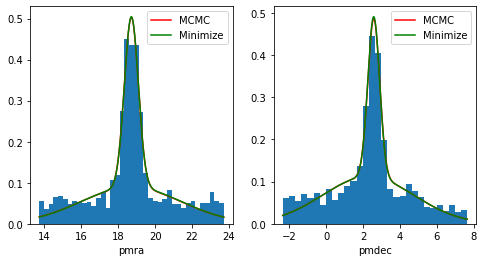

In [32]:
sample_data = df.pmra
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
bin_heights, bin_borders, _ = plt.hist(sample_data, bins='auto',
                                       range=(min(sample_data),max(sample_data)),density=True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x, gaussian_function(x, params_mcmc_pmra), label='MCMC',color='red')
plt.plot(x, gaussian_function(x, results_pmra.x), label='Minimize', color='green')
plt.legend()
plt.xlabel('pmra')

plt.subplot(1,2,2)
sample_data = df.pmdec
bin_heights, bin_borders, _ = plt.hist(sample_data, bins='auto',
                                       range=(min(sample_data),max(sample_data)),density=True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x, gaussian_function(x, params_mcmc_pmdec), label='MCMC',color='red')
plt.plot(x, gaussian_function(x, results_pmdec.x), label='Minimize',color='green')
plt.legend()
plt.xlabel('pmdec')

# 2D Gaussian function

In [17]:
def log_prior(params):
    nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf = params
    if 0.0 < nc < 1.0 and 0.0 < s < 10.0 and 0.0 < sx < 10.0 and 0.0 < sy < 10.0 and -1.0 < rho < 1.0:
        return 0.0
    return -np.inf

def log_likelihood(params, x, y):
    nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf = params
    amp_circ = nc / (2 * np.pi * s**2)
    amp_elip = (1-nc) / (2 * np.pi * sx * sy * np.sqrt(1 - rho**2))
    Exp_circ = -0.5 * (((x - mu_xc)/s)**2 + ((y - mu_yc)/s)**2)
    Exp_elip = -1/(2*(1-rho**2))*(((x - mu_xf)/sx)**2+((y - mu_yf)/sy)**2-2*rho*((x - mu_xf)/sx)*((y - mu_yf)/sy))
    z = amp_circ * np.exp(Exp_circ) + amp_elip * np.exp(Exp_elip)
    # Calculate log likelihood
    return np.sum(np.log(z))

def log_probability(params, x, y):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x, y)

In [18]:
def Metropolis(params, X, Y, a = 0.1, NSteps = int(3e4)):
    
    x = np.ones(( NSteps, len(params) ))
    x[0] = params
    for i in tqdm(range(1, NSteps)):
        nc = x[i-1,0] + a * np.random.normal(loc=0, scale=1.0)
        s = x[i-1,1] + a * np.random.normal(loc=0, scale=1.0)
        sx = x[i-1,2] + a * np.random.normal(loc=0, scale=1.0)
        sy = x[i-1,3] + a * np.random.normal(loc=0, scale=1.0)
        rho = x[i-1,4] + a * np.random.normal(loc=0, scale=1.0)
        mu_xc = x[i-1,5] + a * np.random.normal(loc=0, scale=1.0)
        mu_yc = x[i-1,6] + a * np.random.normal(loc=0, scale=1.0)
        mu_xf = x[i-1,7] + a * np.random.normal(loc=0, scale=1.0)
        mu_yf = x[i-1,8] + a * np.random.normal(loc=0, scale=1.0)
        
        present = log_probability(params, X, Y)
        
        future = log_probability([nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf], X, Y)

        alpha = np.minimum(1, np.exp( future - present ))
        g = np.random.rand()
        
        if alpha > g:
            x[i,0] = nc
            x[i,1] = s
            x[i,2] = sx
            x[i,3] = sy
            x[i,4] = rho
            x[i,5] = mu_xc
            x[i,6] = mu_yc
            x[i,7] = mu_xf
            x[i,8] = mu_yf
        else:
            x[i,:] = x[i-1,:]       
         
    return x[100:,:] # quemamos los primeros xxxx puntos

In [19]:
x = df.pmra
y = df.pmdec
#nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf
rho_matrix = np.corrcoef(df.pmra, df.pmdec)
initparams = [0.5, results_pmra.x[1], results_pmra.x[2], results_pmdec.x[2], rho_matrix[0][1],
       results_pmra.x[3], results_pmdec.x[3], results_pmra.x[4], results_pmdec.x[4]]
print(initparams)
print(log_likelihood(initparams, x, y))
print(log_prior(initparams))
print(log_probability(initparams, x, y))

nll = lambda *args: -log_likelihood(*args)

results = minimize(nll, initparams, args=(x, y), options={"disc":True}, method='Nelder-Mead')
results.x

[0.5, 0.37660488194819, 2.710589268776126, 2.4887773729398934, 0.005438692177041282, 18.716908489737023, 2.581620448400767, 18.70933123204756, 2.2785302983957543]
-5100.656780174095
0.0
-5100.656780174095


array([3.77563169e-01, 3.81145132e-01, 2.68047779e+00, 2.62001150e+00,
       5.97451542e-03, 1.87253873e+01, 2.58418952e+00, 1.87043317e+01,
       2.24143208e+00])

In [80]:
x = df.pmra
y = df.pmdec
initparams = results.x
MCMC = Metropolis(initparams, x, y, 0.005, 500000)

100%|██████████| 499999/499999 [57:07<00:00, 145.88it/s]


Minimize: [3.77563169e-01 3.81145132e-01 2.68047779e+00 2.62001150e+00
 5.97451542e-03 1.87253873e+01 2.58418952e+00 1.87043317e+01
 2.24143208e+00]
MCMC:     [3.78023148e-01 3.82298254e-01 2.67305403e+00 2.62475151e+00
 1.85427396e-04 1.87249014e+01 2.58657081e+00 1.87298501e+01
 2.21617877e+00]


Text(0.5, 0, 'step number')

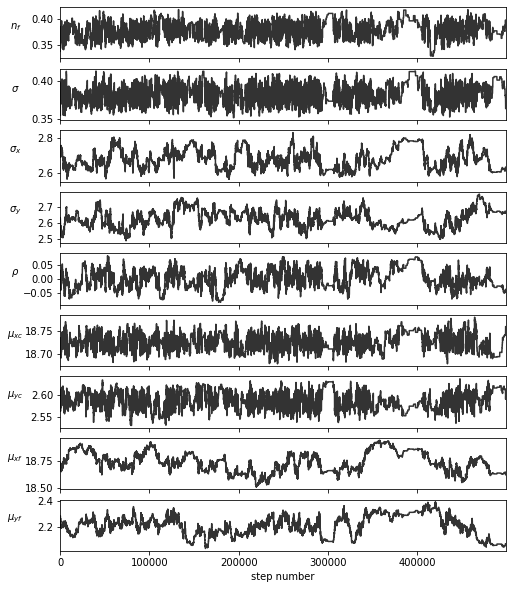

In [81]:
params_mcmc = np.percentile(MCMC ,50, axis=0)
print('Minimize:',results.x)
print('MCMC:    ',params_mcmc)

fig, axes = plt.subplots(len(params_mcmc), figsize=(8, 10), sharex=True)
labels = ["$n_f$", "$\sigma$", "$\sigma_x$", "$\sigma_y$", "$\\rho$",
          "$\mu_{xc}$", "$\mu_{yc}$", "$\mu_{xf}$", "$\mu_{yf}$"]
for i in range(len(params_mcmc)):
    ax = axes[i]
    ax.plot(MCMC[:,i], "k", alpha=0.8)
    ax.set_xlim(0, len(MCMC))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

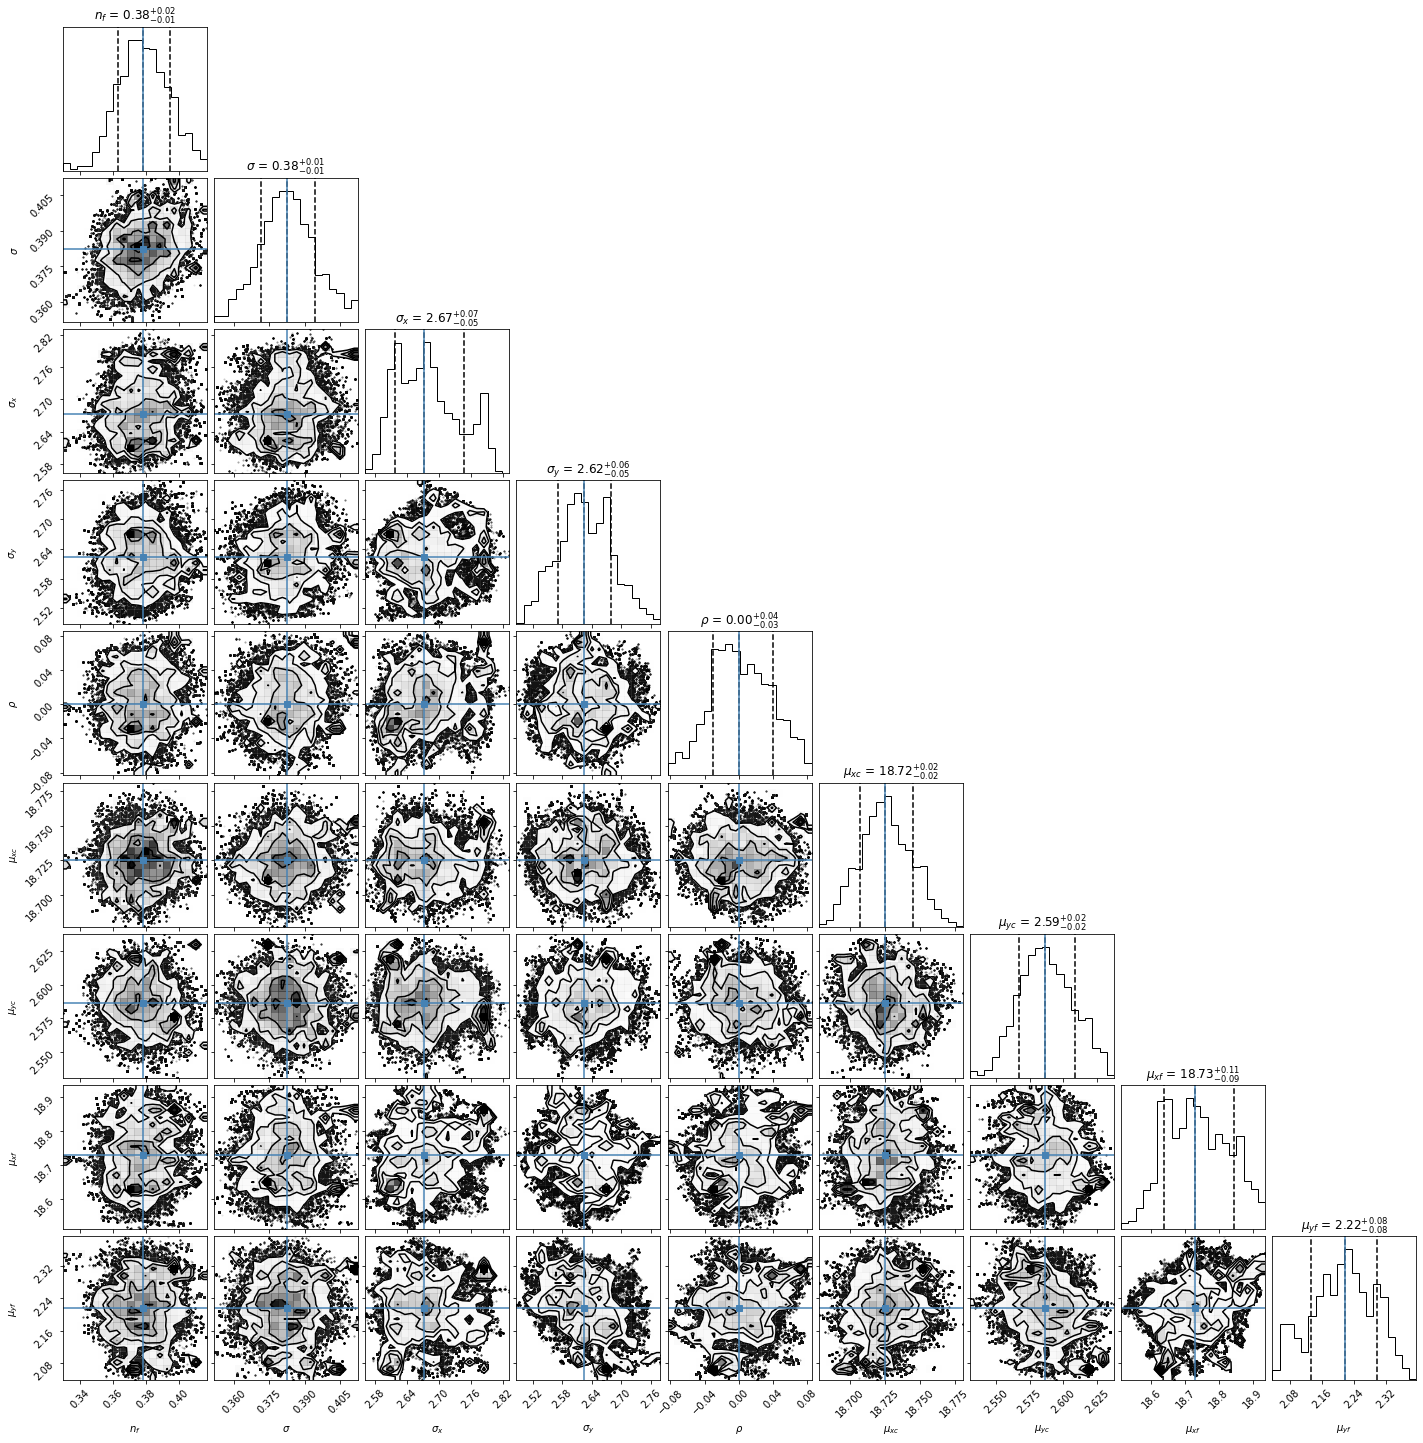

In [82]:
truths = np.percentile(MCMC ,50, axis=0)
#nf, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf
labels = ["$n_f$", "$\sigma$", "$\sigma_x$", "$\sigma_y$", "$\\rho$",
          "$\mu_{xc}$", "$\mu_{yc}$", "$\mu_{xf}$", "$\mu_{yf}$"]
figure = corner.corner(MCMC, labels=labels, truths=truths, quantiles=[0.16, 0.5, 0.84], show_titles=True,
                      title_kwargs={"fontsize": 12})
#plt.savefig('./corner_nine_parameters.jpg',bbox_inches = "tight")

(0.0, 5.0)

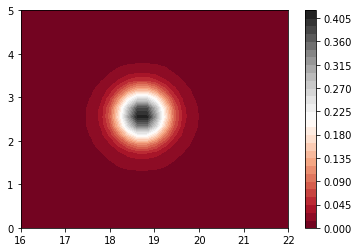

In [20]:
x = np.linspace(min(df.pmra), max(df.pmra), 50)
y = np.linspace(min(df.pmdec), max(df.pmdec), 50)

def func(x, y, params):
    nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf = params
    amp_circ = nc / (2 * np.pi * s**2)
    amp_elip = (1-nc) / (2 * np.pi * sx * sy * np.sqrt(1 - rho**2))
    Exp_circ = -0.5 * (((x - mu_xc)/s)**2 + ((y - mu_yc)/s)**2)
    Exp_elip = -1/(2*(1-rho**2))*(((x - mu_xf)/sx)**2+((y - mu_yf)/sy)**2-2*rho*((x - mu_xf)/sx)*((y - mu_yf)/sy))
    z = amp_circ * np.exp(Exp_circ) + amp_elip * np.exp(Exp_elip)
    return z

X, Y = np.meshgrid(x, y)
Z = func(X, Y, results.x)

plt.contourf(X, Y, Z, 30, cmap='RdGy')
plt.colorbar()
plt.xlim(16,22)
plt.ylim(0,5)

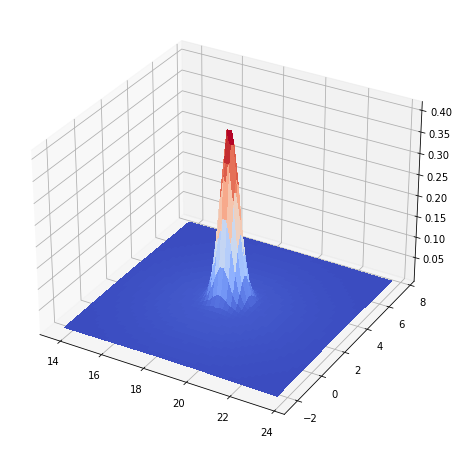

In [21]:
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(8, 8))
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)

0.9672786384862674


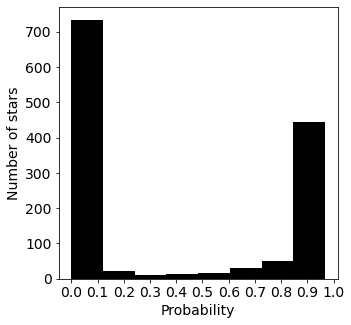

In [22]:
#nf, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf = truths
nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf = results.x

def probabilidad_circ(xy, nc, s, mu_xc, mu_yc):
    x, y = xy
    amp_circ =  1 / (2 * np.pi * s**2)
    Exp_circ = - 1/2 * (((x - mu_xc)/s)**2 + ((y - mu_yc)/s)**2)
    return nc * amp_circ * np.exp(Exp_circ)

def probabilidad_elip(xy, nc, sx, sy, rho, mu_xf, mu_yf):
    x, y = xy
    amp_elip = 1 / (2 * np.pi * sx * sy * np.sqrt(1 - rho**2))
    Exp_elip = - 1/(2*(1-rho**2))*(((x - mu_xf)/sx)**2+((y - mu_yf)/sy)**2-2*rho*((x - mu_xf)/sx)*((y - mu_yf)/sy))
    return (1-nc) * amp_elip * np.exp(Exp_elip)

xy = np.vstack((df.pmra, df.pmdec))
param_circ_prob = (nc, s, mu_xc, mu_yc)
param_elip_prob = (nc, sx, sy, rho, mu_xf, mu_yf)
p_circ = probabilidad_circ(xy, *param_circ_prob)
p_elip = probabilidad_elip(xy, *param_elip_prob)
prob = p_circ / (p_circ + p_elip)
#print('Min: {:.10f} Max: {:.10f}'.format(min(prob), max(prob)))
prob_limit = 0.5
members = (prob >= prob_limit)
no_members = (prob < prob_limit)
print(max(prob))
plt.figure(figsize=(5,5))
#plt.hist(prob, bins=5,range=[min(prob), 0.5], label='Field stars',color='gray')
#plt.hist(prob[(prob > 0.5)], bins=5,color='cyan',label='Cluster stars')
plt.hist(prob, bins=8,range=[min(prob), max(prob)],color='black')#histtype='step'
plt.xlabel('Probability',fontsize=14)
plt.ylabel('Number of stars',fontsize=14)
plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
#plt.axvline(x = 0.5, color = 'black', label = 'Cut off', linestyle = '--')
#plt.legend()
#plt.savefig('./results/pleiades_probabilities.jpg',bbox_inches = "tight")
plt.show()

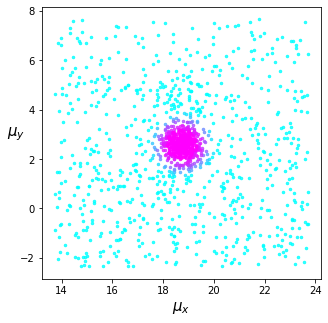

In [23]:
#colors=['black','dimgray','darkgrey','gainsboro','wheat','rosybrown','lightcoral','indianred','salmon','red']
#loop = np.arange(0.0, 1.0, 0.1)
loop = np.arange(0.0, 1.0, 0.1)
colors = [plt.cm.cool(each) for each in np.linspace(0, 1, len(loop))]

plt.figure(figsize=(5,5))
for i,c in zip(loop, colors):
  cond = (prob >= i) & (prob < i + 0.1)
  pmra_, pmdec_ = df.pmra[(cond)], df.pmdec[(cond)]
  plt.plot(pmra_, pmdec_,marker='.',c=c,linestyle='None',markersize=5,alpha=0.8)
plt.xlabel("$\mu_{x}$", fontsize = 15)
plt.ylabel("$\mu_{y}$", fontsize = 15,rotation=0)
#plt.savefig('./VPDClasses.jpg')
plt.show()

In [26]:
df['probability'] = prob
b1_members = df[members]
b1_members.to_csv('./blanco1_PMmodel.csv')
print(len(b1_members))
b1_members

539


,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,...,g,g_error,rp,rp_error,bp,bp_error,rv,rv_error,ruwe,probability
26,2321410616394529664,2.013105,0.107889,-28.542634,0.102375,0.004267,0.000146,18.351631,0.133112,2.101319,...,18.220442,1.336924,16.946337,10.147861,19.945133,7.576601,0.000000,0.000000,0.992830,0.891401
39,2321413949289499776,1.599337,0.112898,-28.675197,0.100794,0.004423,0.000139,18.618613,0.156241,3.016445,...,17.655039,3.992293,16.350252,12.587383,19.331076,10.460187,0.000000,0.000000,1.212059,0.939368
50,2321415770355639808,1.604525,0.074902,-28.626529,0.074045,0.004132,0.000098,18.968678,0.101875,3.005427,...,17.500357,2.161768,16.253736,11.642471,19.157602,11.841854,0.000000,0.000000,0.964683,0.931577
72,2321418828372357376,1.606949,0.123728,-28.601757,0.123154,0.003446,0.000164,19.340565,0.167229,2.515916,...,18.316202,1.497755,17.052030,13.819158,20.121040,8.237848,0.000000,0.000000,1.020896,0.890253
91,2321422436144254464,1.723788,0.010863,-28.519087,0.009532,0.004314,0.000012,19.001442,0.015245,2.876101,...,12.249480,253.744630,11.699513,335.268280,12.625168,345.664300,5.849659,0.816092,0.980313,0.945738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63426,6552310228837948416,-8.395708,0.092235,-34.385971,0.105168,0.004139,0.000122,18.638418,0.100169,2.100478,...,17.884178,2.214029,16.648352,9.659335,19.480875,11.495305,0.000000,0.000000,0.939673,0.927493
64068,6555597596806155904,-9.365232,0.159787,-33.601228,0.181804,0.003893,0.000210,19.419437,0.177755,2.465610,...,18.721153,1.564510,17.436610,12.904814,20.596704,6.808631,0.000000,0.000000,0.982341,0.846988
64185,6551047508455099136,-8.474498,0.015632,-35.815960,0.024522,0.003472,0.000022,18.279932,0.017693,1.694149,...,10.490845,449.734740,9.937252,38012.630000,10.604478,12175.455000,-6.146955,0.990563,1.125977,0.500769
64743,6551351081036094080,-7.869775,0.052169,-36.069601,0.059183,0.004240,0.000071,18.710232,0.058153,2.427297,...,16.768750,3.594643,15.602242,13.329209,18.147795,16.311998,0.000000,0.000000,0.986898,0.964271


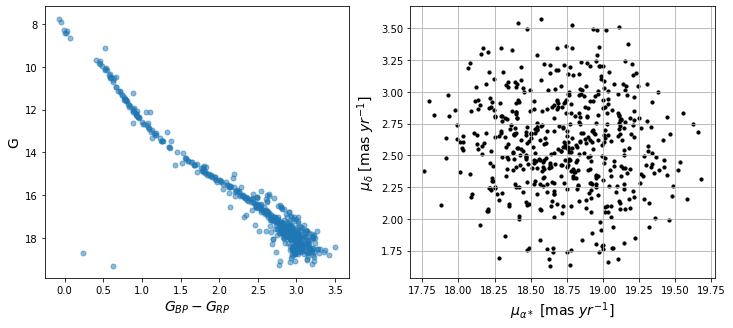

In [27]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
#plt.plot(pleiades['bp'] - pleiades['rp'], pleiades['g'],color='black',marker='.',linestyle='None',markersize=1,alpha=0.5)
plt.plot(b1_members['bp'] - b1_members['rp'], b1_members['g'],marker='o',linestyle='None',markersize=5,alpha=0.5)
#plt.text(4.2, 5.5, 'Pleiades',fontsize=15)
plt.xlabel("$G_{BP}-G_{RP}$", fontsize = 14)
plt.ylabel("G", fontsize = 14)
plt.gca().invert_yaxis()
#plt.savefig('./images_pm/pleiades_CMD_pm.jpg',bbox_inches = "tight")

plt.subplot(1,2,2)
#plt.plot(m44['pmra'], m44['pmdec'], color = 'black', marker = '.',linestyle = 'None', markersize = 1, alpha = 1)
plt.scatter(b1_members['pmra'], b1_members['pmdec'], color = 'black', marker = 'o', s = 10, alpha = 1)
plt.xlabel('$\mu_{\\alpha *}$ [mas $yr^{-1}$]',  fontsize = 14)
plt.ylabel("$\mu_{\delta}$ [mas $yr^{-1}$]",  fontsize = 14)
#plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5],fontsize=14)
#plt.xticks([17, 18, 19, 20, 21],fontsize=14)
plt.grid()
#plt.savefig('./images_pm/pleiades_vpd_pm.jpg',bbox_inches = "tight")
plt.show()

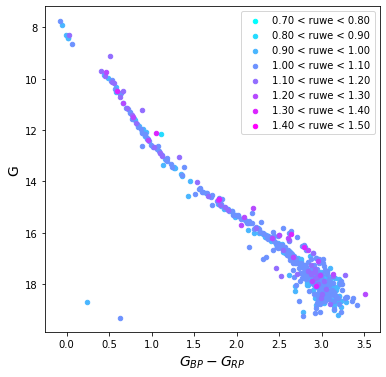

In [28]:
loop = np.arange(0.7, 1.5, 0.1)
colors = [plt.cm.cool(each) for each in np.linspace(0, 1, len(loop))]
plt.figure(figsize=(6,6))
for i,c in zip(loop, colors):
  cond = (b1_members.ruwe >= i) & (b1_members.ruwe < i + 0.1)
  color, g_mag = b1_members['bp'][(cond)]-b1_members['rp'][(cond)], b1_members['g'][(cond)]
  plt.scatter(color, g_mag,marker='o',color=c,s=20,alpha=1,label='{:.2f} < ruwe < {:.2f}'.format(i,i+0.1))
plt.gca().invert_yaxis()
plt.legend(fontsize = 10)
plt.xlabel("$G_{BP}-G_{RP}$", fontsize = 14)
plt.ylabel("G", fontsize = 14)
#plt.savefig('./results/pleiades_cmd_ruwe.jpg',bbox_inches = "tight")
plt.show()

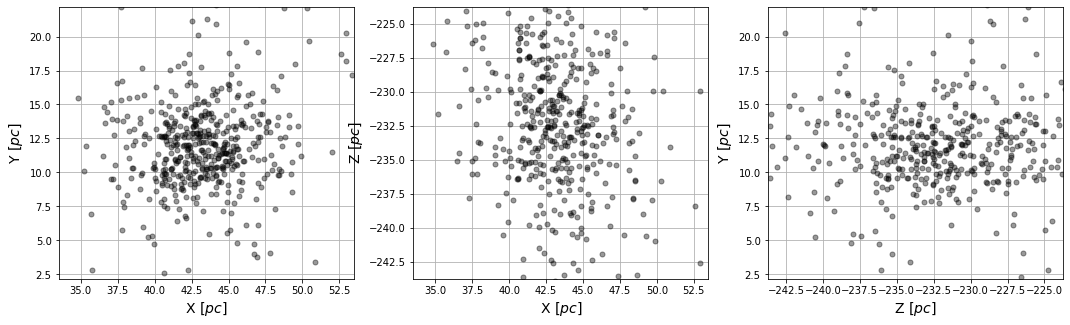

In [29]:
import astropy.units as u
import astropy.coordinates as apycoords

df_test = b1_members

ra_ = df_test['ra'] *u.deg
dec_ = df_test['dec'] *u.deg
distance_ = np.array(1/df_test['parallax']) *u.pc

c = apycoords.SkyCoord(ra=ra_,dec=dec_,distance=distance_,frame='icrs')
#print("(X,Y,Z) in (kpc,kpc,kpc)")
#print("\t",c.galactic.cartesian)
x = c.galactic.cartesian.x
y = c.galactic.cartesian.y
z = c.galactic.cartesian.z

xp = np.mean(x.to_value())
yp = np.mean(y.to_value())
zp = np.mean(z.to_value())
value = 10

%matplotlib inline
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.plot(x, y,color='k',marker='o',linestyle='None',markersize=5,alpha=0.4)
plt.xlim(xp - value,xp + value)
plt.ylim(yp - value,yp + value)
plt.xlabel("X $[pc]$", fontsize = 14)
plt.ylabel("Y $[pc]$", fontsize = 14)#,rotation=0)
plt.grid()

plt.subplot(1,3,2)
plt.plot(x, z,color='k',marker='o',linestyle='None',markersize=5,alpha=0.4)
plt.xlim(xp - value,xp + value)
plt.ylim(zp - value,zp + value)
plt.xlabel("X $[pc]$", fontsize = 14)
plt.ylabel("Z $[pc]$", fontsize = 14)#,rotation=0)
plt.grid()

plt.subplot(1,3,3)
plt.plot(z, y,color='k',marker='o',linestyle='None',markersize=5,alpha=0.4)
plt.xlim(zp - value,zp + value)
plt.ylim(yp - value,yp + value)
plt.xlabel("Z $[pc]$", fontsize = 14)
plt.ylabel("Y $[pc]$", fontsize = 14)#,rotation=0)
plt.grid()
#plt.savefig('./results/distribucion_espacial_test.jpg')
plt.show()